In [3]:
import blimpy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import h5py
from zipfile import ZipFile
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython import display
%matplotlib inline

In [2]:
filepathZip = '../HIP45493.zip'
def read_zip_file(filepath):
    """
    Unzips a zip file given the filepath of the zip. If filepath is a zip and the function finds that the 
    unzipped version already exists, will return 'This file has already been unzipped'.
    """
    zip1title = filepath[0:-4]
    cwd = os.getcwd()
    pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    if os.path.isdir(zip1title) == True:
        print('This file has already been unzipped.')
        nameList = [] 
        for file in os.listdir(zip1title):
            file = zip1title + '/' + file
            nameList.append(file)
        return(nameList)
    elif os.path.isfile(filepath) == False and filepath[-4:] == '.zip':
        print("The zipfile you entered isn't in the previous directory with respect to your current working directory: " + cwd)
        print("Please check that you've downloaded the file and move the zip file from the Downloads section (or wherever you saved it) to the parent directory: " + pdir)
    elif filepath[-4:] != '.zip':
        print("The file you entered is not a zipfile. Please enter a zipfile.")
    elif os.path.isfile(filepath) == True:
        zip1 = ZipFile(filepath)
        nameList = zip1.namelist()
        newNameList = []
        for name in nameList:
            name = '../' + name 
            newNameList.append(name)
        zip1.extractall('../')
        zip1.close()
        os.remove(filepath)
        return(newNameList)
        
observationFilepaths = read_zip_file(filepathZip)

def h5_header_wrapper(filename):
    """
    Gets header of a .h5 file.
    """
    h = h5py.File(filename)
    header = dict(h['data'].attrs.items())
    return header

def waterfallfunc(filepath):
    """
    Reads .h5 filepath into waterfall filterbank data
    """
    return(blimpy.Waterfall(filepath))

waterfalls = [waterfallfunc(filepath) for filepath in observationFilepaths]
hd = [h5_header_wrapper(filepath) for filepath in observationFilepaths]
titles = [str(hd[0]['source_name']), str(hd[1]['source_name']), str(hd[2]['source_name']), str(hd[3]['source_name']), str(hd[4]['source_name']), str(hd[5]['source_name'])]
titles = [titles[0][2:-1].upper(), titles[1][2:-1].upper(), titles[2][2:-1].upper(), titles[3][2:-1].upper(), titles[4][2:-1].upper(), titles[5][2:-1].upper()]

def waterfallTime(waterfall):
    """
    Returns the timestamps of the waterfall file's data
    """
    return(waterfall.populate_timestamps())

def waterfallFreqs(waterfall):
    """
    Returns the frequencies of the waterfall file's data
    """
    return(waterfall.populate_freqs())

def waterfallData(waterfall):
    """
    Extracts the actual data of the waterfall file
    """
    return(waterfall.data[:, 0, :])

def waterfallSize(waterfall):
    """
    Extracts the size of the data of the waterfall file
    """
    return(waterfall.data[:, 0, :].shape)

times = [waterfallTime(waterfall) for waterfall in waterfalls]
freqs = [waterfallFreqs(waterfall) for waterfall in waterfalls]
data = [waterfallData(waterfall) for waterfall in waterfalls]
size = [waterfallSize(waterfall) for waterfall in waterfalls]

def elapsedTime(times):
    """
    Converting timestamps from MJD time into seconds elapsed since first observation
    """
    timesElapsedDays = times - times[0]
    timesElapsedSeconds = timesElapsedDays * 86400
    return(timesElapsedSeconds)

telapsed = [elapsedTime(time) for time in times]


def locateTime(obsNumber, vertIndex):
    """
    Extracting the time of each datapoint, given the vertical index of the 
    datapoint and the obsNumber. The obsNumber is the observation number of the waterfall
    file, or in other words, denotes the place of the observation in the cadence. obsNumber
    is 1-6.
    """
    if obsNumber == 1:
        time = telapsed[0][vertIndex]
    elif obsNumber == 2:
        time = telapsed[1][vertIndex]
    elif obsNumber == 3:
        time = telapsed[2][vertIndex]
    elif obsNumber == 4:
        time = telapsed[3][vertIndex]
    elif obsNumber == 5:
        time = telapsed[4][vertIndex]
    elif obsNumber == 6:
        time = telapsed[5][vertIndex]
    return(time)

def locateFreq(obsNumber, horizIndex):
    """
    Extracting the frequency of each datapoint, given the vertical index of the 
    datapoint and the obsNumber. The obsNumber is the observation number of the waterfall
    file, or in other words, denotes the place of the observation in the cadence. obsNumber
    is 1-6.
    """
    if obsNumber == 1:
        freq = freqs[0][horizIndex]
    elif obsNumber == 2:
        freq = freqs[1][horizIndex]
    elif obsNumber == 3:
        freq = freqs[2][horizIndex]
    elif obsNumber == 4:
        freq = freqs[3][horizIndex]
    elif obsNumber == 5:
        freq = freqs[4][horizIndex]
    elif obsNumber == 6:
        freq = freqs[5][horizIndex]
    return(freq)

def reorganizingAllAsList(data, obsNumber):
    """
    Finding the time and freq for every data entry and putting them into a separate list. Input for function should
    be a waterfall data (refer to data list). horizDim corresponds to freq. vertDim corresponds to time.
    """
    plotTime = []
    plotFreqs = []
    dataAsList = []
    horizDim = data.shape[1]
    vertDim = data.shape[0]
    for i in range(vertDim):
        for j in range(horizDim):
            plotTime.append(locateTime(obsNumber, i))
            plotFreqs.append(locateFreq(obsNumber, j))
            dataAsList.append(data[i, j])
    return(plotFreqs, plotTime, dataAsList)

def reorganizingAllAsArray(data, obsNumber):
    """
    Finding the time and freq for every data entry and putting them into an array. Input for function should
    be a waterfall data (refer to data list). horizDim corresponds to freq. vertDim corresponds to time.
    """
    plotFreqs, plotTime, dataAsList = reorganizingAllAsList(data, obsNumber)
    horizDim = data.shape[1]
    vertDim = data.shape[0]
    dataAsArray = np.array(dataAsList).reshape(vertDim, horizDim)
    plotFreqsArray = np.array(plotFreqs).reshape(vertDim, horizDim)
    plotTimeArray = np.array(plotTime).reshape(vertDim, horizDim)
    return(plotFreqsArray, plotTimeArray, dataAsArray)

def ticksArray(obsNum):
    """
    Finding the frequency ticks for an observation number's data and putting them into an array. 
    Input for function should be an observation number (1-6). horizDim corresponds to 
    freq. vertDim corresponds to time. The frequency ticks will be used for plotting the ticks
    on the x axis. 
    """
    dataObs = data[obsNum - 1] 
    freqsArray,_,_ = reorganizingAllAsArray(dataObs, obsNum)
    freqsLin = np.around(np.linspace(np.amin(freqsArray), np.amax(freqsArray), 6), 2)
    freqsLinTicks = np.around(np.linspace(freqsLin[1], freqsLin[-1], 4), 2)
    return(freqsLinTicks)

numbers = [1, 2, 3, 4, 5, 6]
ticks = [ticksArray(obsNum) for obsNum in numbers]

def waterfall_plot_on(index):
    """
    Will plot the waterfall plots for the on observations given the index of the plot on the figure. 
    1, 2, 3 are the indices for graphs on the first row, which are the on observations.
    """
    plt.subplot(int('23' + str(index)), title = titles[2*(index - 1)], xticks = ticks[2*(index - 1)])
    waterfalls[2*(index - 1)].plot_waterfall()
    plt.title(titles[2*(index-1)])
    
def waterfall_plot_off(index):
    """
    Will plot the waterfall plots for the off observations given the index of the plot on the figure. 
    4, 5, 6 are the indices for graphs on the second row, which are the off observations.
    """
    plt.subplot(int('23'+str(index)), title = titles[2*index - 7], xticks = ticks[2*index - 7])
    waterfall_off = waterfalls[2*index - 7]
    waterfall_off.plot_waterfall()
    plt.title(titles[2*index - 7])

def Plot6Plots(saveAs):
    """
    Plotting the 6 plots of the observation. saveAs has 3 options: png, pdf, None. 
    saveAs decides what file to save plots as. 
    """
    plt.rc('text', usetex=True)
    plt.rc('font', size = 16, family='serif')
    plt.rc('axes', titlesize = 16, labelsize = 16)
    plt.rc('xtick', labelsize = 14)
    plt.rc('ytick', labelsize = 14)
    title1, title2, title3, title4, title5, title6 = titles[0], titles[1], titles[2], titles[3], titles[4], titles[5]
    display.clear_output(wait=True)
    plt.figure(figsize = (19, 10))
    [waterfall_plot_on(index) for index in [1, 2, 3]]
    [waterfall_plot_off(index) for index in [4, 5, 6]]
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    plt.show()
    if saveAs.lower() == 'png':
        fig.savefig(titles[0] + '_6plots.png', dpi = 600)
    elif saveAs.lower() == 'pdf':
        fig.savefig(titles[0] + '_6plots.pdf')
    else:
        pass

This file has already been unzipped.


interactive(children=(Dropdown(description='saveAs', options=('None', 'PNG', 'pdf'), value='None'), Output()),…

<function __main__.Plot6Plots(saveAs)>

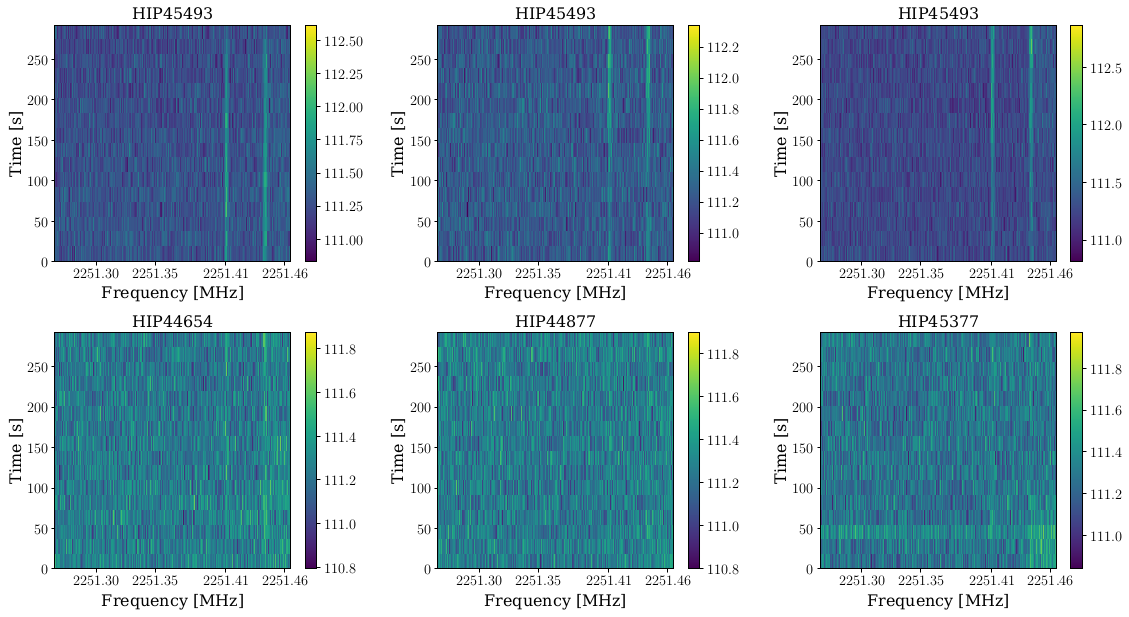

In [23]:
interact(Plot6Plots, saveAs = ['None', 'PNG', 'pdf'])